In [1]:
from __future__ import (absolute_import, division, print_function,unicode_literals)

In [2]:
import datetime  # datetime类型处理
import tushare as ts 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import backtrader as bt

In [14]:
class TestStrategy(bt.Strategy):
    ##bt策略

    def log(self, txt, dt=None, doprint=False):
        ##日志函数，用于统一输出日志格式
        if doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):

        # 初始化相关数据
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # 五日移动平均线
        self.sma5 = bt.indicators.SimpleMovingAverage(self.datas[0], period=5)
        #self.sma5 = bt.indicators.SimpleMovingAverage(self.data.close, period=5)
        # 十日移动平均线
        self.sma10 = bt.indicators.SimpleMovingAverage(self.datas[0], period=10)
        #self.sma10 = bt.indicators.SimpleMovingAverage(self.data.close, period=10)


    def next(self):
        #正式交易

        # 记录收盘价
        self.log('Close, %.2f' % self.dataclose[0])

        # 是否正在下单，如果是的话不能提交第二次订单
        if self.order:
            return

        # 是否有持仓
        if not self.position:
            # 没有，如果 MA5 > MA10 说明涨势，买入
            if self.sma5 > self.sma10:
                self.order = self.buy()
        else:
            # 有，如果 MA5 < MA10 ，说明跌势，卖出
            if self.sma5 < self.sma10:
                self.order = self.sell()


In [4]:
def get_data(code,start,end):
    pro = ts.pro_api()
    df = ts.pro_bar(ts_code=code, adj='qfq', start_date=start, end_date=end)
    df.index=pd.to_datetime(df.trade_date)
    df.sort_index(ascending=True,inplace=True)
    df=df.rename(columns={'vol':'volume'})
    df['openinterest']=0
    df=df[['open','high','low','close','volume','openinterest']]
    return df

In [15]:
#股票代码
code='600000.sh'
#回测期间
start=datetime(2019, 6, 30)#起始时间
end=datetime(2021, 2, 10)
d1=start.strftime('%Y%m%d')
d2=end.strftime('%Y%m%d')
dataframe=get_data(code,d1,d2)
# 加载数据
data = bt.feeds.PandasData(dataname=dataframe,fromdate=start,todate=end)

In [16]:
dataframe

,open,high,low,close,volume,openinterest
trade_date,,,,,,
2019-07-01,11.2478,11.3047,11.0865,11.1055,548878.82,0
2019-07-02,11.1150,11.1340,10.9727,11.0107,511657.29,0
2019-07-03,11.0201,11.0296,10.9158,10.9632,365670.85,0
2019-07-04,11.0107,11.0676,10.9727,11.0201,303692.01,0
2019-07-05,11.0296,11.0391,10.9348,10.9727,257532.41,0
...,...,...,...,...,...,...
2021-02-04,10.2100,10.4100,10.1200,10.2800,920164.50,0
2021-02-05,10.2800,10.8200,10.2500,10.7200,1955061.62,0
2021-02-08,10.7100,10.8100,10.5100,10.7200,1370895.06,0


In [17]:
import backtrader.analyzers as btay#添加分析函数
# 初始化cerebro回测系统设置                           
cerebro = bt.Cerebro()  
#将数据传入回测系统
cerebro.adddata(data) 
# 将交易策略加载到回测系统中
cerebro.addstrategy(TestStrategy) 
# 设置初始资本为10000
startcash = 10000
cerebro.broker.setcash(startcash)
cerebro.addsizer(bt.sizers.FixedSize, stake=300)#每次交易300股
# 设置交易手续费为 0.05%
cerebro.broker.setcommission(commission=0.0005) 

In [18]:
d1=start.strftime('%Y%m%d')
d2=end.strftime('%Y%m%d')
print(f'初始资金: {startcash}\n回测期间：{d1}:{d2}')
# 添加分析对象
cerebro.addanalyzer(btay.SharpeRatio,_name="sharpe")
# 运行回测
results = cerebro.run()
#获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash
#打印结果
print(f'总资金: {round(portvalue,2)}')
print(f'净收益: {round(pnl,2)}')
print("夏普比例:", results[0].analyzers.sharpe.get_analysis())

初始资金: 10000
回测期间：20190630:20210210
总资金: 9924.92
净收益: -75.08
夏普比例: OrderedDict([('sharperatio', -0.2804069648386722)])


<IPython.core.display.Javascript object>


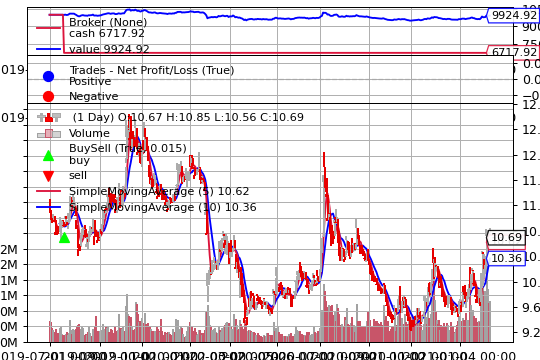

[[<Figure size 432x288 with 4 Axes>]]

In [19]:
cerebro.plot(style='candlestick')